In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
# i prefer PIL to draw the text, more beautiful
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

This image is: <class 'numpy.ndarray'> with dimension: (540, 960, 3)


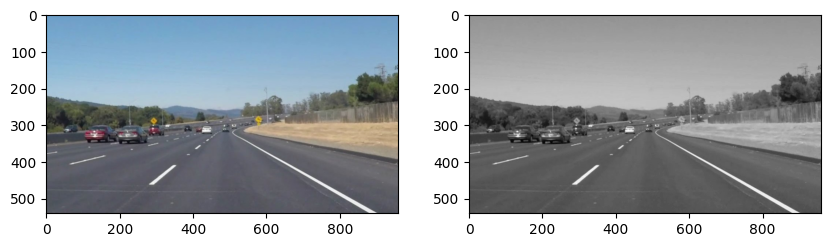

In [2]:
image = cv2.imread('/home/veeransh/Desktop/self-driven-car-ai/Data/straight_line.png')
print('This image is:', type(image), 'with dimension:', image.shape)
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cmap = 'gray')
plt.show()

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

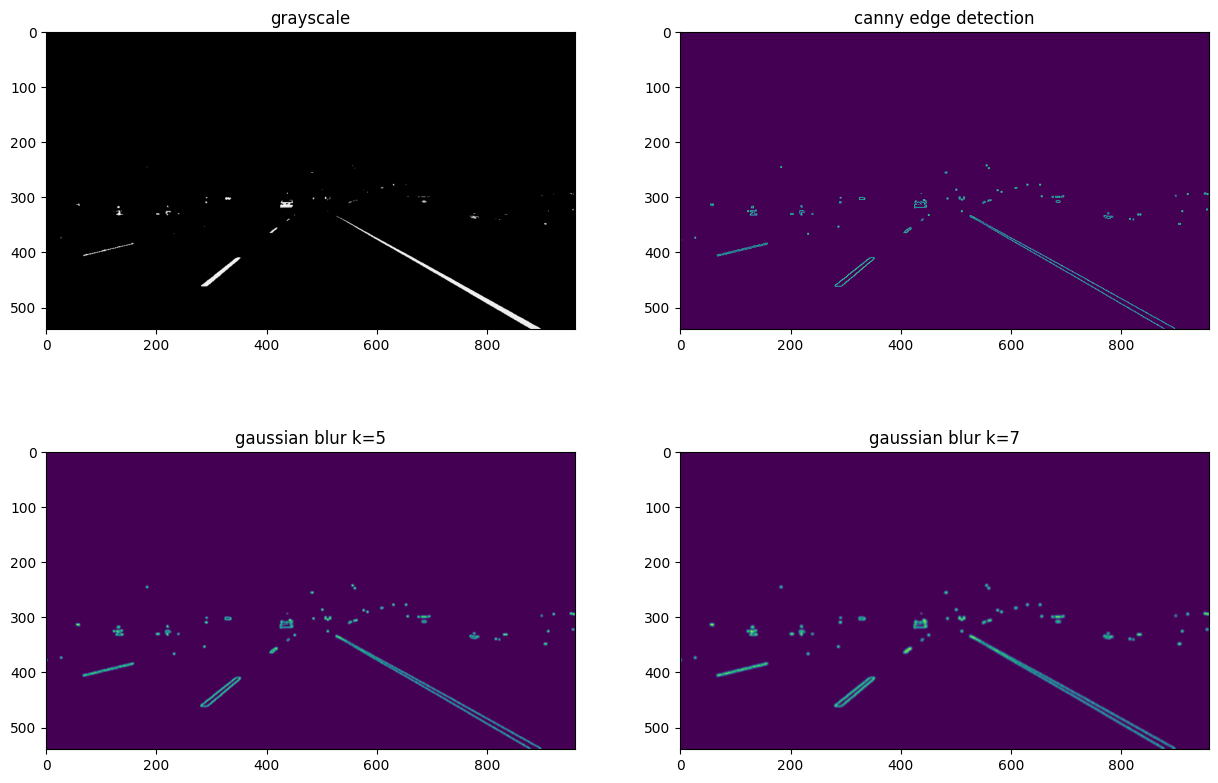

In [4]:
plt.figure(figsize = (15, 10))

filtered_color = select_rgb_white_yellow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(2, 2, 1)
plt.imshow(grayscale(filtered_color), cmap = 'gray')
plt.title('grayscale')

plt.subplot(2, 2, 2)
plt.imshow(canny(filtered_color, 100, 150))
plt.title('canny edge detection')

plt.subplot(2, 2, 3)
plt.imshow(gaussian_blur(canny(filtered_color, 100, 150), 5))
plt.title('gaussian blur k=5')

plt.subplot(2, 2, 4)
plt.imshow(gaussian_blur(canny(filtered_color, 100, 150), 7))
plt.title('gaussian blur k=7')

plt.show()

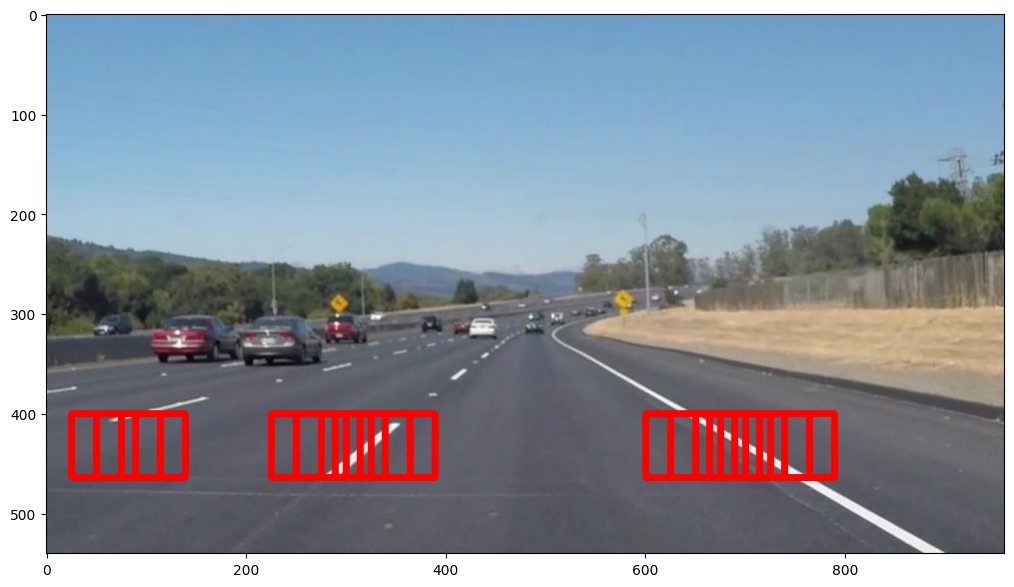

In [5]:
copied = np.copy(gaussian_blur(canny(filtered_color, 100, 150), 7))
filter_size = 64
stride = 25
start_y = 400
w_range = int((copied.shape[1] - filter_size) / stride + 1)
bboxes = []
for _w in range(w_range):
    if copied[start_y:start_y+filter_size,_w * stride:_w * stride + filter_size].mean() > 1:
        bboxes.append([start_y, _w * stride, start_y+filter_size, _w * stride + filter_size])

copied = np.copy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
for ymin, xmin, ymax, xmax in bboxes:
    cv2.rectangle(copied,(xmin,ymin),(xmax,ymax),(255,0,0),5)
plt.figure(figsize = (15, 7))
plt.imshow(copied)
plt.show()



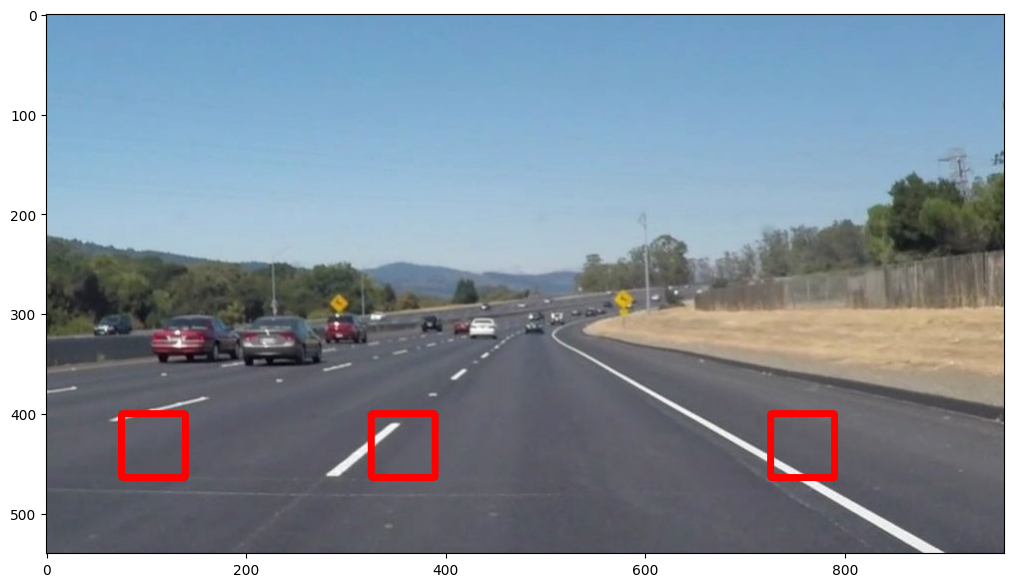

CPU times: user 325 ms, sys: 162 ms, total: 487 ms
Wall time: 211 ms


In [6]:


%%time
# longer nearest boxes supression

boxes = np.array(bboxes)
x1 = boxes[:,1]
x2 = boxes[:,3]
idxs = np.arange(x1.shape[0])
pick = []
while len(idxs) > 0:
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    suppress = [last]
    for pos in range(0, last):
        j = idxs[pos]
        overlap = abs(x2[j] - x2[i])
        if overlap < filter_size*3:
            suppress.append(pos)
    idxs = np.delete(idxs, suppress)
    
copied = np.copy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
for i in boxes[pick].astype("int"):
    cv2.rectangle(copied,(i[1],i[0]),(i[3],i[2]),(255,0,0),5)
plt.figure(figsize = (15, 7))
plt.imshow(copied)
plt.show()



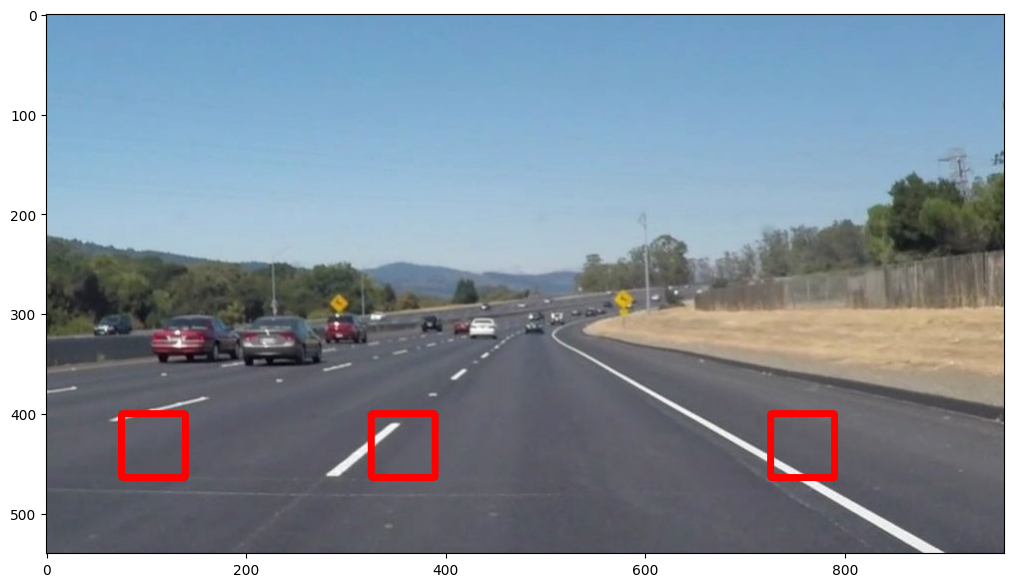

CPU times: user 379 ms, sys: 185 ms, total: 563 ms
Wall time: 276 ms


In [7]:
%%time
# shorter nearest boxes suppression

boxes = np.array(bboxes)
x1 = boxes[:,1]
x2 = boxes[:,3]
idxs = np.arange(x1.shape[0])
pick = []
while len(idxs) > 0:
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    xx2 = x2[idxs[:last]]
    overlap = abs(xx2 - x2[i])
    idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap < filter_size*3)[0])))

copied = np.copy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
for i in boxes[pick].astype("int"):
    cv2.rectangle(copied,(i[1],i[0]),(i[3],i[2]),(255,0,0),5)
plt.figure(figsize = (15, 7))
plt.imshow(copied)
plt.show()

In [ ]:
plt.figure(figsize = (15, 7))
copied = np.copy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
for i in boxes[pick].astype("int"):
    cv2.rectangle(copied,(i[1],i[0]),(i[3],i[2]),(255,0,0),5)
    
pil_image = Image.fromarray(np.uint8(copied))
draw = ImageDraw.Draw(pil_image)
font = ImageFont.truetype('/home/veeransh/Desktop/self-driven-car-ai/Data/other/Roboto-Regular.ttf', 60)

draw.text((10,10),'total lane detected: %d'%(len(pick)),fill='white',font=font)
plt.imshow(np.array(pil_image))
plt.show()